In [2]:
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=1)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
from math import pi

In [3]:
PC = pd.read_excel("rubber.xlsx",sheet_name="stub")
PC['P_PcS']=PC['P']/((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)/pi*1000.0
X=PC[['D', 't', 'L', 'Fy', 'fc','%R']]
y=PC['P_PcS']
OUT_RANGE=(1,2)#important (better than (-1,1)) as I minimize the neg_mean_absolute_percentage_error
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=OUT_RANGE)
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=42)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-02-13 13:55:29,908] A new study created in memory with name: no-name-e5b04aed-618b-441e-8c45-6259a1d61140
[I 2024-02-13 13:55:30,236] Trial 1 finished with value: 0.31791395327557936 and parameters: {'n_estimators': 32, 'learning_rate': 0.021341579044041433, 'gamma': 0.010504117823427438, 'max_depth': 45, 'booster': 'dart'}. Best is trial 1 with value: 0.31791395327557936.
[I 2024-02-13 13:55:30,252] Trial 2 finished with value: 0.11162647032082511 and parameters: {'n_estimators': 605, 'learning_rate': 0.006326465410391743, 'gamma': 4.605074508949855, 'max_depth': 29, 'booster': 'dart'}. Best is trial 2 with value: 0.11162647032082511.
[I 2024-02-13 13:55:30,955] Trial 7 finished with value: 0.43021070440306897 and parameters: {'n_estimators': 136, 'learning_rate': 0.002766142624802911, 'gamma': 4.040308553055416, 'max_depth': 25, 'booster': 'gbtree'}. Best is trial 2 with value: 0.11162647032082511.
[I 2024-02-13 13:55:31,076] Trial 0 finished with value: 0.06607630321910808 a

Best hyperparameters: {'n_estimators': 1306, 'learning_rate': 0.18098603218462103, 'gamma': 0.010063297466114049, 'max_depth': 15, 'booster': 'gbtree'}
Best RMSE: 0.04822862071466615


In [37]:

#Best hyperparameters: {'n_estimators': 1306, 'learning_rate': 0.18098603218462103, 'gamma': 0.010063297466114049, 'max_depth': 15, 'booster': 'gbtree'}
aa=xgb.XGBRegressor(random_state=1000,n_estimators=1306, max_depth=15, learning_rate=0.18098603218462103, booster='gbtree', gamma=0.010063297466114049)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','%R','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'XGB_Circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.03938349164939664
Data exported to XGB_Circ.xlsx


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-02-13 14:07:09,004] A new study created in memory with name: no-name-609fcb5b-9bef-4f99-8f6d-b9d759bd79f0
[I 2024-02-13 14:07:13,698] Trial 1 finished with value: 0.08817531844200055 and parameters: {'n_estimators': 950, 'learning_rate': 0.0013825227099522484, 'max_depth': 24, 'num_leaves': 26, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.08817531844200055.
[I 2024-02-13 14:07:15,815] Trial 0 finished with value: 0.07644032229230446 and parameters: {'n_estimators': 1506, 'learning_rate': 0.003978558036330158, 'max_depth': 49, 'num_leaves': 27, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.07644032229230446.
[I 2024-02-13 14:07:16,426] Trial 4 finished with value: 0.09543477979858053 and parameters: {'n_estimators': 434, 'learning_rate': 0.0011667800869734246, 'max_depth': 46, 'num_leaves': 22, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.07644032229230446.
[I 2024-02-13 14:07:17,073] Trial 2 finished with value: 0.45051034429394854 and parameters

Best hyperparameters: {'n_estimators': 1919, 'learning_rate': 0.08006768224791255, 'max_depth': 41, 'num_leaves': 23, 'boosting_type': 'dart'}
Best RMSE: 0.05627404073678562


In [39]:
aa=LGBMRegressor(n_estimators=1919,learning_rate=0.08006768224791255, max_depth=41, num_leaves=23, boosting_type='dart')
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','%R','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'LGBM_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

c:\Users\osama\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 116, number of used features: 6
[LightGBM] [Info] Start training from score 1.386632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)#os.cpu_count()-1
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-02-13 14:01:11,172] A new study created in memory with name: no-name-0f086699-65c1-442c-9ae7-5f79bd13ec9b
[I 2024-02-13 14:01:12,611] Trial 4 finished with value: 0.10127419340215 and parameters: {'n_estimators': 442, 'max_depth': 45, 'min_samples_leaf': 42, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 4 with value: 0.10127419340215.
[I 2024-02-13 14:01:13,056] Trial 1 finished with value: 0.0702283189020133 and parameters: {'n_estimators': 820, 'max_depth': 38, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.0702283189020133.
[I 2024-02-13 14:01:13,579] Trial 2 finished with value: 0.11377600045916307 and parameters: {'n_estimators': 180, 'max_depth': 44, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.0702283189020133.
[I 2024-02-13 14:01:13,788] Trial 0 finished with value: 0.11383053317904812 and parameters: {'n_estimators': 1182, 'max_depth': 25, 'min_samples_

Best hyperparameters: {'n_estimators': 929, 'max_depth': 30, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}
Best RMSE: 0.048333052708738555


In [41]:
#'n_estimators': 929, 'max_depth': 30, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False
aa=RandomForestRegressor(random_state=1000,n_estimators=929, max_depth=30, min_samples_leaf=2, max_features='log2', bootstrap=False)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','%R','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'RF_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.04901094800027727


c:\Users\osama\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.030949545078550758
Data exported to RF_circ.xlsx


In [4]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-02-13 15:03:51,511] A new study created in memory with name: no-name-63666ef1-61a5-4b86-9f54-71fea79141dc
[I 2024-02-13 15:04:04,285] Trial 2 finished with value: 0.054203918151224474 and parameters: {'iterations': 1218, 'learning_rate': 0.014973724105263457, 'depth': 2, 'subsample': 0.16138698992411782, 'colsample_bylevel': 0.3859936381637155, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.054203918151224474.
[I 2024-02-13 15:04:07,743] Trial 8 finished with value: 0.0818970489911006 and parameters: {'iterations': 862, 'learning_rate': 0.0027900500383526918, 'depth': 12, 'subsample': 0.5000899263078314, 'colsample_bylevel': 0.2544273353772381, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.054203918151224474.
[I 2024-02-13 15:04:12,403] Trial 9 finished with value: 0.09589569352554608 and parameters: {'iterations': 544, 'learning_rate': 0.0014863111293587463, 'depth': 13, 'subsample': 0.4244547256637153, 'colsample_bylevel': 0.36827849547280433, 'min_data_in_leaf

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/algo/tensor_search_helpers.cpp:554: Too few sampling units (subsample=0.0562454, bootstrap_type=MVS): please increase sampling rate or disable sampling


In [43]:
#'iterations': 1593, 'learning_rate': 0.048486530266134586, 'depth': 5, 'subsample': 0.24646806288193535, 'colsample_bylevel': 0.16442613637496806, 'min_data_in_leaf': 64}. Best is trial 49 with value: 0.04370634293787065.
aa=cb.CatBoostRegressor(iterations=1593,learning_rate=0.048486530266134586,depth=5,subsample=0.24646806288193535,colsample_bylevel=0.16442613637496806,min_data_in_leaf= 64)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','%R','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'Cat_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.1904416	total: 383us	remaining: 611ms
1:	learn: 0.1904416	total: 708us	remaining: 564ms
2:	learn: 0.1904416	total: 767us	remaining: 407ms
3:	learn: 0.1872231	total: 994us	remaining: 395ms
4:	learn: 0.1869046	total: 1.12ms	remaining: 356ms
5:	learn: 0.1824592	total: 1.3ms	remaining: 345ms
6:	learn: 0.1804831	total: 1.4ms	remaining: 316ms
7:	learn: 0.1793350	total: 1.54ms	remaining: 306ms
8:	learn: 0.1773469	total: 1.73ms	remaining: 304ms
9:	learn: 0.1757810	total: 1.86ms	remaining: 294ms
10:	learn: 0.1738820	total: 2.01ms	remaining: 289ms
11:	learn: 0.1733743	total: 2.14ms	remaining: 283ms
12:	learn: 0.1700244	total: 2.43ms	remaining: 295ms
13:	learn: 0.1670823	total: 2.74ms	remaining: 309ms
14:	learn: 0.1665962	total: 2.83ms	remaining: 298ms
15:	learn: 0.1665252	total: 2.91ms	remaining: 287ms
16:	learn: 0.1665249	total: 2.97ms	remaining: 276ms
17:	learn: 0.1665247	total: 3.06ms	remaining: 268ms
18:	learn: 0.1657734	total: 3.19ms	remaining: 265ms
19:	learn: 0.1654007	total: 

In [47]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-02-13 15:36:05,982] A new study created in memory with name: no-name-a155dbb7-2c26-4a47-9f9b-3493864c5795
[I 2024-02-13 15:36:19,986] Trial 2 finished with value: 0.05050767753507692 and parameters: {'iterations': 1763, 'learning_rate': 0.0804695215991733, 'depth': 8, 'subsample': 0.13590850850203506, 'colsample_bylevel': 0.3951001392585881, 'min_data_in_leaf': 43}. Best is trial 2 with value: 0.05050767753507692.
[I 2024-02-13 15:36:23,766] Trial 4 finished with value: 0.06997211777558762 and parameters: {'iterations': 1706, 'learning_rate': 0.0014448372720531038, 'depth': 8, 'subsample': 0.882547309934114, 'colsample_bylevel': 0.8537575061008927, 'min_data_in_leaf': 83}. Best is trial 2 with value: 0.05050767753507692.
[I 2024-02-13 15:36:27,230] Trial 0 finished with value: 0.0867722378194086 and parameters: {'iterations': 585, 'learning_rate': 0.002033691422115572, 'depth': 15, 'subsample': 0.5891285691099815, 'colsample_bylevel': 0.5324035619964984, 'min_data_in_leaf': 100

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/algo/tensor_search_helpers.cpp:554: Too few sampling units (subsample=0.0507355, bootstrap_type=MVS): please increase sampling rate or disable sampling


In [48]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-02-13 15:48:43,629] A new study created in memory with name: no-name-f99b889d-2577-472d-a7b0-c8e142595277
[I 2024-02-13 15:48:49,636] Trial 5 finished with value: 0.08034807884711356 and parameters: {'iterations': 494, 'learning_rate': 0.0273161177520342, 'depth': 15, 'subsample': 0.36812106877180506, 'colsample_bylevel': 0.05779301654221542, 'min_data_in_leaf': 24}. Best is trial 5 with value: 0.08034807884711356.
[I 2024-02-13 15:48:50,870] Trial 3 finished with value: 0.09113014464092044 and parameters: {'iterations': 1624, 'learning_rate': 0.0031233517368974045, 'depth': 15, 'subsample': 0.5834350401840479, 'colsample_bylevel': 0.08325221651054898, 'min_data_in_leaf': 96}. Best is trial 5 with value: 0.08034807884711356.
[I 2024-02-13 15:48:51,671] Trial 0 finished with value: 0.04459996931326501 and parameters: {'iterations': 264, 'learning_rate': 0.06139946451190565, 'depth': 4, 'subsample': 0.6614241011395003, 'colsample_bylevel': 0.3408088593565116, 'min_data_in_leaf': 

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/algo/tensor_search_helpers.cpp:554: Too few sampling units (subsample=0.0531617, bootstrap_type=MVS): please increase sampling rate or disable sampling


In [49]:
#'iterations': 1166, 'learning_rate': 0.05899914585963138, 'depth': 5, 'subsample': 0.20268159422778917, 'colsample_bylevel': 0.22042450295436278, 'min_data_in_leaf': 78}. Best is trial 204 with value: 0.042385792918983256.
aa=cb.CatBoostRegressor(iterations=1166,learning_rate=0.05899914585963138,depth=5,subsample=0.20268159422778917,colsample_bylevel=0.22042450295436278,min_data_in_leaf= 78)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','%R','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'Cat_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.1919042	total: 800us	remaining: 933ms
1:	learn: 0.1875137	total: 1.68ms	remaining: 980ms
2:	learn: 0.1826424	total: 2.08ms	remaining: 808ms
3:	learn: 0.1820436	total: 2.25ms	remaining: 653ms
4:	learn: 0.1774192	total: 2.91ms	remaining: 675ms
5:	learn: 0.1728030	total: 3.37ms	remaining: 651ms
6:	learn: 0.1705286	total: 3.56ms	remaining: 590ms
7:	learn: 0.1679525	total: 3.74ms	remaining: 542ms
8:	learn: 0.1667787	total: 4.01ms	remaining: 515ms
9:	learn: 0.1667783	total: 4.12ms	remaining: 476ms
10:	learn: 0.1637401	total: 4.61ms	remaining: 484ms
11:	learn: 0.1623079	total: 4.95ms	remaining: 476ms
12:	learn: 0.1610575	total: 5.2ms	remaining: 461ms
13:	learn: 0.1592102	total: 5.85ms	remaining: 482ms
14:	learn: 0.1592100	total: 6ms	remaining: 460ms
15:	learn: 0.1580115	total: 6.31ms	remaining: 454ms
16:	learn: 0.1547659	total: 6.7ms	remaining: 453ms
17:	learn: 0.1519409	total: 7.12ms	remaining: 454ms
18:	learn: 0.1494909	total: 7.55ms	remaining: 456ms
19:	learn: 0.1478677	total: 

In [358]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from tabulate import tabulate


# Read the data from the Excel file
PC = pd.read_excel("rubber.xlsx",sheet_name="stub")
# Calculate y2 based on the provided formula
pi = np.pi
PC['lam1']=PC['D']/PC['t']*PC['Fy']/208000.0
PC['D_t']=PC['D']/PC['t'];PC['L_D']=PC['L']/PC['D']
PC['P_PcS'] = PC['P'] / (((PC['D'] - PC['t']) * PC['t'] * PC['Fy']) + ((PC['D'] - 2.0 * PC['t']) ** 2.0 * PC['fc'] / 4.0)) / pi * 1000.0

# Create a list to store the statistical properties for each feature
features = ['D', 't', 'L', 'Fy', 'fc','%R', 'D_t', 'L_D', 'P', 'P_PcS']
X1=PC[['D', 't', 'L', 'Fy', 'fc','%R', 'D_t', 'L_D', 'P', 'P_PcS']]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)



              D         t         L        Fy        fc        %R       D_t  \
D      1.000000  0.620088  0.755873 -0.341434 -0.020012  0.093684  0.359952   
t      0.620088  1.000000  0.382350 -0.317149  0.139204  0.028359 -0.481637   
L      0.755873  0.382350  1.000000 -0.151851 -0.219484  0.081566  0.413683   
Fy    -0.341434 -0.317149 -0.151851  1.000000  0.149754 -0.315477 -0.029064   
fc    -0.020012  0.139204 -0.219484  0.149754  1.000000 -0.475512 -0.254898   
%R     0.093684  0.028359  0.081566 -0.315477 -0.475512  1.000000  0.117967   
D_t    0.359952 -0.481637  0.413683 -0.029064 -0.254898  0.117967  1.000000   
L_D   -0.203453 -0.297410  0.469485  0.240421 -0.411451 -0.001073  0.186993   
P      0.900702  0.746143  0.657067 -0.289807  0.270500 -0.082226  0.094535   
P_PcS  0.260417  0.261381  0.106070 -0.506321 -0.195379  0.049447  0.015295   

            L_D         P     P_PcS  
D     -0.203453  0.900702  0.260417  
t     -0.297410  0.746143  0.261381  
L      0.469485 

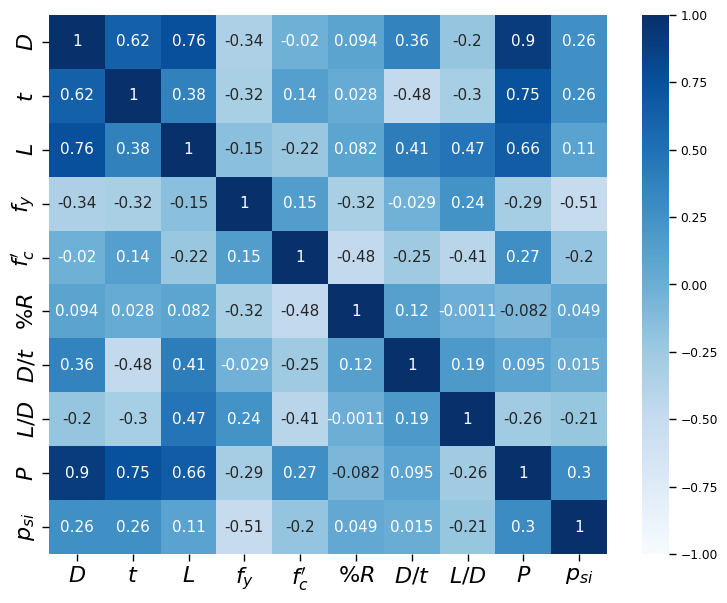

In [364]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

PC = pd.read_excel("rubber.xlsx",sheet_name="stub")
pi = np.pi
PC['lam1']=PC['D']/PC['t']*PC['Fy']/208000.0
PC['D_t']=PC['D']/PC['t'];PC['L_D']=PC['L']/PC['D']
PC['P_PcS'] = PC['P'] / (((PC['D'] - PC['t']) * PC['t'] * PC['Fy']) + ((PC['D'] - 2.0 * PC['t']) ** 2.0 * PC['fc'] / 4.0)) / pi * 1000.0
PC_CIRC=PC
X1 = PC[['D', 't', 'L', 'Fy', 'fc','%R', 'D_t', 'L_D', 'P', 'P_PcS']]
column_labels = ['$D$', '$t$', '$L$', '$f_y$', '$f^\\prime_c$','$\\%R$','$D/t$', '$L/D$','$P$','$p_{si}$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(9, 7),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_circ.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()


C:\Users\osama\AppData\Local\Temp\ipykernel_15452\971996757.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.rcParams['font.sans-serif'] = 'Times New Roman';sns.distplot(PC['P_PcS'], fit=norm)
C:\Users\osama\AppData\Local\Temp\ipykernel_15452\971996757.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = pl


 mu = 1.33 and sigma = 0.24


 mu = 1047.42 and sigma = 761.32



<Figure size 3840x2880 with 0 Axes>

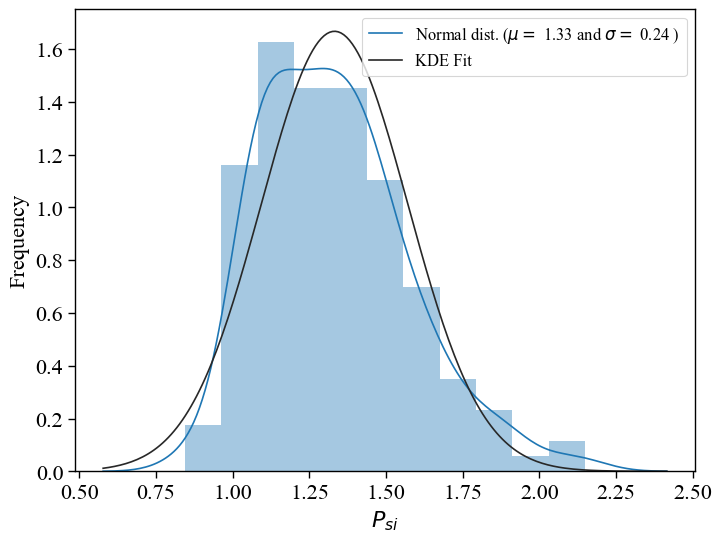

<Figure size 3840x2880 with 0 Axes>

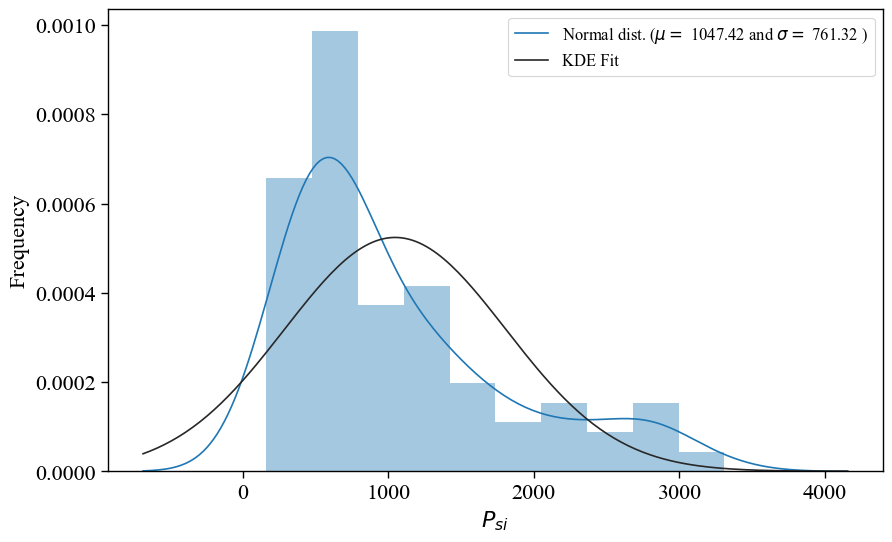

In [11]:
from scipy.stats import norm, skew
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pi = np.pi
PC=PC_CIRC

sns.set_context("paper", rc={"font.size": 20, "axes.titlesize": 20, "axes.labelsize": 20})

fig = plt.figure(dpi=600);plt.figure(figsize=(8, 6))

plt.rcParams['font.sans-serif'] = 'Times New Roman';sns.distplot(PC['P_PcS'], fit=norm)
(mu, sigma) = norm.fit(PC['P_PcS'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'KDE Fit'],loc='upper right', fontsize=12)
plt.ylabel('Frequency', fontsize=16);plt.xlabel("$P_{si}$", fontsize=16);plt.tick_params(axis='x', labelsize=16);plt.tick_params(axis='y', labelsize=16)
plt.savefig("Distribution_circ.png")

fig = plt.figure(dpi=600);plt.figure(figsize=(10, 6));plt.rcParams['font.sans-serif'] = 'Times New Roman';sns.distplot(PC['P'], fit=norm)
(mu, sigma) = norm.fit(PC['P'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'KDE Fit'],loc='upper right', fontsize=12)
plt.ylabel('Frequency', fontsize=16);plt.xlabel("$P_{si}$", fontsize=16);plt.tick_params(axis='x', labelsize=16);plt.tick_params(axis='y', labelsize=16)
plt.savefig("Distribution_circ_before.png")

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
pi = math.pi
from sklearn.model_selection import cross_val_score

# Load the data
PC = pd.read_excel("rubber.xlsx",sheet_name="stub")
PC['P_PcS'] = PC['P'] / ((PC['D'] - PC['t']) * PC['t'] * PC['Fy'] + (PC['D'] - 2.0 * PC['t']) ** 2.0 * PC['fc'] / 4.0) / pi * 1000.0
X = PC[['D', 't', 'L', 'Fy', 'fc','%R']]
y = PC['P_PcS']
X, y = np.array(X.values), np.array(y.values)

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1));out_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X);y_normalized = out_scaler.fit_transform(y.reshape(-1, 1))
X_tot=X_normalized;y_tot=y_normalized
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.0005,0.0007,0.001,0.0013,0.003,0.01,0.1]  # Add more values if needed
alpha_values = [0.0002]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred


c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_pr

In [24]:
print(best_alpha)

0.0002


In [25]:
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','%R','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'Gpr_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred

Data exported to Gpr_circ.xlsx


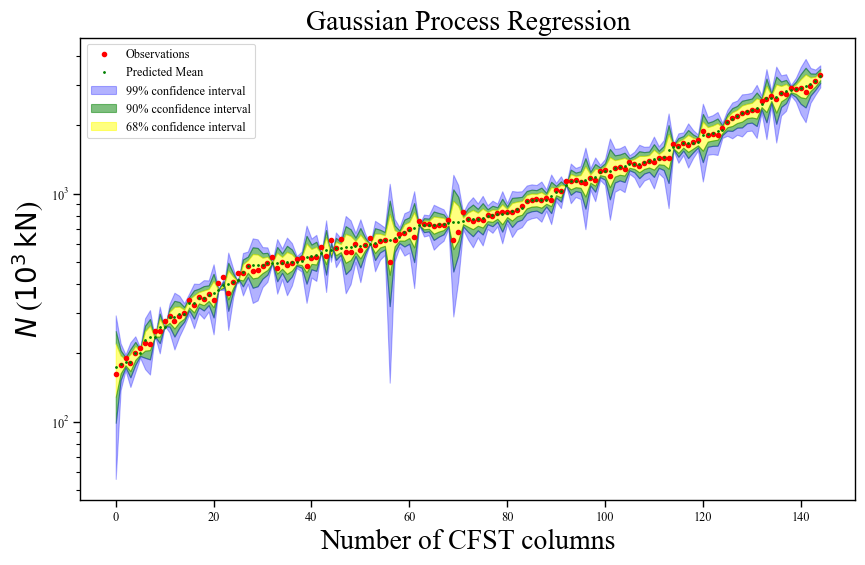

In [27]:

y_tot11=y_tot;X_tot11=X_tot;y_pred11=y_pred;y_std2=y_std
yr=y_std2.reshape(-1, 1)+y_pred.reshape(-1, 1)
data = out_scaler.inverse_transform( y_tot11.reshape(-1, 1))
data1= out_scaler.inverse_transform(y_pred11.reshape(-1, 1))
yr   = out_scaler.inverse_transform(yr.reshape(-1, 1))
y_std2=yr.reshape(-1, 1)-data.reshape(-1, 1)
X     =     scaler.inverse_transform(X_tot)

data2=np.concatenate((X,data.reshape(-1, 1),data1.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','%R','P_exp','P_pred'];PC=df;PC['sd']=y_std2;#PC['sd']=np.clip(y_std2, 0, 0.3)
PC['multi']=((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_exp']=PC['P_exp']*PC['multi'];PC['P_pred']=PC['P_pred']*PC['multi'];PC['sd']=PC['sd']*PC['multi']
y_tot11=np.array(PC['P_exp'].values);y_pred11=np.array(PC['P_pred'].values);y_std2=np.array(PC['sd'].values)

#arrange
vv = np.vstack((X_tot11.transpose(),y_std2,y_tot11,y_pred11)).transpose()
v1 = vv[np.argsort(vv[:, -1])]
#previous sheet excel is wrong as you didnot sort x_tot
X_tot11,y_std2,y_tot11,y_pred11=v1[:,:-3],v1[:,-3],v1[:,-2],v1[:,-1]
# Calculate the upper and lower confidence bounds
#0.674
#2.576 is 99% confidence 1.96 is 95%confidence interval #1.645 is 90% #2.576 for 99% #1.0 for 68%
lower_bound99 = y_pred11.flatten() - 2.576* y_std2.flatten();upper_bound99 = y_pred11.flatten() + 2.576* y_std2.flatten()#99% confidence
lower_bound90 = y_pred11.flatten() - 1.645* y_std2.flatten();upper_bound90 = y_pred11.flatten() + 1.645* y_std2.flatten()#1.645 is 90%
lower_bound68 = y_pred11.flatten() - 1.0  * y_std2.flatten();upper_bound68 = y_pred11.flatten() + 1.0  * y_std2.flatten()#1.0 for 68%
# Plot the data, true function, and confidence intervals
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
# Fill between the confidence bounds
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.savefig("GPR_Predicted_Mean_Confidence_Intervals1i.png", dpi=500)
plt.show()


In [29]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection._split import check_cv
from sklearn.base import is_classifier, clone
from joblib import Parallel
from sklearn.utils.fixes import delayed
from sklearn.utils.validation import _check_fit_params
from sklearn.utils.metaestimators import _safe_split
rand_stat=42
def cross_val_predict(estimator,X,y=None,*,groups=None,cv=None,n_jobs=None,verbose=0,
    fit_params=None,pre_dispatch="2*n_jobs",method="predict",XX):#XX  is added to crossfold

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    splits = list(cv.split(X, y, groups))
    test_indices = np.concatenate([test for _, test in splits])    
    parallel = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)
    ppp = parallel(
        delayed(_fit_and_predict)(clone(estimator), X, y, train, test, verbose, fit_params, method,XX=XX)
        for train, test in splits)
    
    inv_test_indices = np.empty(len(test_indices), dtype=int)
    inv_test_indices[test_indices] = np.arange(len(test_indices))
    predictions=[];y_pred_tot=[]
    for i in range(len(ppp)):
        predictions.append(ppp[i][0])
        y_pred_tot.append(ppp[i][1])                    #this line is added to crossfold
    pred = np.concatenate(predictions)
    return pred[inv_test_indices],y_pred_tot            #y_pred_tot is added to crossfold
def _fit_and_predict(estimator, X, y, train, test, verbose, fit_params, method,XX):#XX  is added to crossfold
    fit_params = fit_params if fit_params is not None else {}
    fit_params = _check_fit_params(X, fit_params, train)

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, _ = _safe_split(estimator, X, y, test, train)

    estimator.fit(X_train, y_train, **fit_params)
    func = getattr(estimator, method)
    predictions = func(X_test)
    p_red = func(XX)                                    #this line is added to crossfold
    return predictions,p_red
nfoldy=5
feature_range=(0,7)
PC = pd.read_excel("rubber.xlsx",sheet_name="stub")
PC['P_PcS']=PC['P']/((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)/pi*1000.0
X=PC[['D', 't', 'L', 'Fy', 'fc','%R']];y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));output_scaler = MinMaxScaler(feature_range=feature_range)
X_normalized = scaler.fit_transform(X);y_normalized = output_scaler.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.2, random_state=rand_stat)

X_normalized=np.concatenate((X_test, X_train), axis=0);X=np.concatenate((X_test1, X_train1), axis=0);y=np.concatenate((y_test1, y_train1), axis=0)
model = MLPRegressor(hidden_layer_sizes=5, activation='logistic',max_iter=100000, solver='lbfgs', random_state=42)
kfold = KFold(n_splits=nfoldy, shuffle=True, random_state=42)
y_pred_train,p_red = cross_val_predict(model, X_train, y_train.ravel(), cv=kfold,XX=X_normalized)
y_pred_train = output_scaler.inverse_transform(y_pred_train.reshape(-1, 1))
rr=y_normalized*0.0
for i in range(nfoldy):#not found in normal fold
    rr+=np.array(p_red[i]).reshape(-1, 1)/nfoldy
y_pred_tot = output_scaler.inverse_transform(rr)


#visulaization
data1=np.concatenate((X,y.reshape(-1, 1)),axis=1)
data2=np.concatenate((data1,y_pred_tot[:,-1].reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','%R','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*  ((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename ='ML_circ.xlsx'
df.to_excel(filename, index=False)

print(np.std(data2[:,-2]/data2[:,-1]),np.mean(data2[:,-2]/data2[:,-1])) #0.06421353092185479 0.9994000056676541

c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklear

0.06098195642435301 0.9955345593598454


c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


Eurcode4 VS AISC360

In [373]:
#circular
rand_stat=42
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from math import pi
import math
PC = pd.read_excel("rubber.xlsx",sheet_name="stub")
X_normalized = PC[['D', 't', 'L', 'Fy', 'fc','%R']]
y_normalized = PC['P']
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
Xc=np.concatenate((X_test, X_train), axis=0)
yc=np.concatenate((y_test, y_train), axis=0)
#GB
def calculate_N_GB1(D,t,L,f_y,f_c):
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    eta=f_y * A_s/f_c / A_c;a1=0.138*f_y/215+0.765;a2=-0.073*f_c/15+0.022
    N_DJB=(A_s+A_c)*(1.212+a1*eta+a2*eta**2.0)*f_c
    return N_DJB/1000.0,N_DJB/(f_y * A_s + f_c * A_c)
#GB
def calculate_N_GB2(D,t,L,f_y,f_c):
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    eta=f_y * A_s/f_c / A_c;a1=0.176*f_y/235+0.974;a2=-0.104*f_c/20+0.031
    N_DJB=(A_s+A_c)*(1.212+a1*eta+a2*eta**2.0)*f_c
    return N_DJB/1000.0,N_DJB/(f_y * A_s + f_c * A_c)
# DBJ
def calculate_N_DBJ(D,t,L,f_y,f_c):
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    N_DJB=(A_s+A_c)*(1.14+1.02*f_y * A_s/f_c / A_c)*f_c
    return N_DJB/1000.0,N_DJB/(f_y * A_s + f_c * A_c)

# EN1994 (2004)
def calculate_N_EC(D,t,L,f_y,f_c):
    E_s = 200000;E_c = 4400*f_c**0.50
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    I_s=(D)**4.0/64.0*pi-(D-2.0*t)**4.0/64.0*pi;I_c =(D-2.0*t)**4.0/64.0*pi
    N_pl = f_y * A_s + 0.85 * f_c * A_c
    N_cr = (math.pi ** 2 * (E_s * I_s + 0.6 * E_c * I_c)) / L ** 2
    lambda_val =min(0.5, math.sqrt(N_pl / N_cr))
    eta_a = min(0.25 * (3 + 2 * lambda_val), 1.0)
    eta_c = max(4.9 - 18.5 * lambda_val + 17 * lambda_val ** 2, 0)
    N_EC = eta_a * f_y * A_s + (1 + eta_c * t / D * f_y / f_c) * f_c * A_c
    return N_EC/1000.0,N_EC/(f_y * A_s + f_c * A_c)

# AISC 360 (2016)
def calculate_N_AISC(D,t,L,f_y,f_c):
    E_s = 200000;E_c = 4400*f_c**0.50
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    N_pl = f_y * A_s + 0.95 * f_c * A_c
    N_y = f_y * A_s + 0.7 * f_c * A_c
    lambda_p = 0.15*E_s / f_y
    lambda_r = 0.19*E_s / f_y
    lambda_val = D / t
    if lambda_val < lambda_p:
        N_AISC = N_pl
    elif lambda_p < lambda_val < lambda_r:
        N_AISC = N_pl - (N_pl - N_y) * ((lambda_val - lambda_p) / (lambda_r - lambda_p)) ** 2
    else:
        N_AISC = 0.72*f_y* A_s/(D/t/E_s*f_y)**0.2 + 0.7 * f_c * A_c       #(9 * E_s * A_s) / lambda_val ** 2
    return N_AISC/1000.0,N_AISC/(f_y * A_s + f_c * A_c)
def calculate_prop(D,t,L,f_y,f_c,R):
    a,b,c,e,f,h=np.array([0.83,2.0,  4.8,0.9,1.3,-0.81])
    f_f=f_c/f_y;D_t=D/t;L_D=L/D;A_s = (D-t)*t*pi;A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    aaaa=(a**f_c*(A_c*f_c)**(b*f_f + c/D_t) + h*R/100+ e + f/np.maximum(L_D,1.5))*A_c*f_c + A_s*f_y
    return aaaa/1000.0,aaaa/(f_y * A_s + f_c * A_c)


# Test the functions
N_EC=np.zeros_like(yc);N_AISC=np.zeros_like(yc);N_DBJ=np.zeros_like(yc);N_GB=np.zeros_like(yc);N_GBI=np.zeros_like(yc);Prop1=np.zeros_like(yc)
N_EC1=np.zeros_like(yc);N_AISC1=np.zeros_like(yc);N_DBJ1=np.zeros_like(yc);N_GB1=np.zeros_like(yc);N_GBI1=np.zeros_like(yc);Prop1=np.zeros_like(yc);yc1=np.zeros_like(yc)
N_prop=np.zeros_like(yc);N_prop1=np.zeros_like(yc);
yc1ii=np.zeros_like(yc)
PC1 = pd.read_excel("ML_circ.xlsx");Prop = PC1['P_pred']
for i in range(len(yc)):
    D,t,L,f_y,f_c,RR=Xc[i,:]
    N_EC[i],N_EC1[i] = calculate_N_EC(D,t,L,f_y,f_c)
    N_AISC[i],N_AISC1[i] = calculate_N_AISC(D,t,L,f_y,f_c)
    N_DBJ[i],N_DBJ1[i] = calculate_N_DBJ(D,t,L,f_y,f_c)
    N_GB[i],N_GB1[i] = calculate_N_GB1(D,t,L,f_y,f_c)
    N_GBI[i],N_GBI1[i] = calculate_N_GB2(D,t,L,f_y,f_c)
    N_prop[i],N_prop1[i] = calculate_prop(D,t,L,f_y,f_c,RR)
    A_c = (D-2.0*t)**2.0/4.0*pi;        A_s = (D-t)*t*pi
    Prop1[i] = Prop[i]/(f_y * A_s + f_c * A_c)*1000.0
    yc1[i] = yc[i]/(f_y * A_s + f_c * A_c)*1000.0
    yc1ii[i] = yc1[i]/Prop1[i]
print(len(Prop1),len(Prop),len(N_AISC))
# Print the results
ai=yc1/N_EC1;print("EN1994 (2004): N^EC =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc1/N_AISC1;print("AISC 360 (2016): N^AISC =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc1/N_DBJ1;print("DBJ: N^DBJ =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc1/N_GB1;print("DBJ: N^DBJ =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc1/N_GBI1;print("DBJ: N^DBJ =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc1/N_prop1;print("prop: N^prop =", np.mean(ai),np.std(ai)/np.mean(ai))

PC['P_exp']=yc;PC['P_pred']=N_EC;filename = 'EC4_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_AISC;filename = 'AISC_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_DBJ;filename = 'DBJ_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_GB;filename = 'GB1_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_GBI;filename = 'GB2_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_prop;filename = 'prop_Circ.xlsx'
PC.to_excel(filename, index=False)

145 145 145
EN1994 (2004): N^EC = 1.0530253903035383 0.17977778258071134
AISC 360 (2016): N^AISC = 1.3633189245879636 0.1803403038204928
DBJ: N^DBJ = 1.1329230305783307 0.1798930344534618
DBJ: N^DBJ = 1.194003645650739 0.18510154503711831
DBJ: N^DBJ = 1.0539564155583985 0.18691461245134913
prop: N^prop = 0.9903020678184801 0.13158610325075804


In [83]:
#circular
rand_stat=42
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
PC = pd.read_excel("recycle.xlsx",sheet_name="Sheet1")
X_normalized = PC[['D', 't', 'L', 'Fy', 'fc','r%']]
y_normalized = PC['P']
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
Xc=np.concatenate((X_test, X_train), axis=0)
yc=np.concatenate((y_test, y_train), axis=0)
#GB
def calculate_N_GB1(D,t,L,f_y,f_c):
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    eta=f_y * A_s/f_c / A_c;a1=0.138*f_y/215+0.765;a2=-0.073*f_c/15+0.022
    N_DJB=(A_s+A_c)*(1.212+a1*eta+a2*eta**2.0)*f_c
    return N_DJB/1000.0,N_DJB/(f_y * A_s + f_c * A_c)
#GB
def calculate_N_GB2(D,t,L,f_y,f_c):
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    eta=f_y * A_s/f_c / A_c;a1=0.176*f_y/235+0.974;a2=-0.104*f_c/20+0.031
    N_DJB=(A_s+A_c)*(1.212+a1*eta+a2*eta**2.0)*f_c
    return N_DJB/1000.0,N_DJB/(f_y * A_s + f_c * A_c)
# DBJ
def calculate_N_DBJ(D,t,L,f_y,f_c):
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    N_DJB=(A_s+A_c)*(1.14+1.02*f_y * A_s/f_c / A_c)*f_c
    return N_DJB/1000.0,N_DJB/(f_y * A_s + f_c * A_c)

# EN1994 (2004)
def calculate_N_EC(D,t,L,f_y,f_c):
    E_s = 200000;E_c = 4400*f_c**0.50
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    I_s=(D)**4.0/64.0*pi-(D-2.0*t)**4.0/64.0*pi;I_c =(D-2.0*t)**4.0/64.0*pi
    N_pl = f_y * A_s + 0.85 * f_c * A_c
    N_cr = (math.pi ** 2 * (E_s * I_s + 0.6 * E_c * I_c)) / L ** 2
    lambda_val =min(0.5, math.sqrt(N_pl / N_cr))
    eta_a = min(0.25 * (3 + 2 * lambda_val), 1.0)
    eta_c = max(4.9 - 18.5 * lambda_val + 17 * lambda_val ** 2, 0)
    N_EC = eta_a * f_y * A_s + (1 + eta_c * t / D * f_y / f_c) * f_c * A_c
    return N_EC/1000.0,N_EC/(f_y * A_s + f_c * A_c)

# AISC 360 (2016)
def calculate_N_AISC(D,t,L,f_y,f_c):
    E_s = 200000;E_c = 4400*f_c**0.50
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    N_pl = f_y * A_s + 0.95 * f_c * A_c
    N_y = f_y * A_s + 0.7 * f_c * A_c
    lambda_p = 0.15*E_s / f_y
    lambda_r = 0.19*E_s / f_y
    lambda_val = D / t
    if lambda_val < lambda_p:
        N_AISC = N_pl
    elif lambda_p < lambda_val < lambda_r:
        N_AISC = N_pl - (N_pl - N_y) * ((lambda_val - lambda_p) / (lambda_r - lambda_p)) ** 2
    else:
        N_AISC = 0.72*f_y* A_s/(D/t/E_s*f_y)**0.2 + 0.7 * f_c * A_c       #(9 * E_s * A_s) / lambda_val ** 2
    return N_AISC/1000.0,N_AISC/(f_y * A_s + f_c * A_c)

# Test the functions
N_EC=np.zeros_like(yc);N_AISC=np.zeros_like(yc);N_DBJ=np.zeros_like(yc);N_GB=np.zeros_like(yc);N_GBI=np.zeros_like(yc);Prop1=np.zeros_like(yc)
N_EC1=np.zeros_like(yc);N_AISC1=np.zeros_like(yc);N_DBJ1=np.zeros_like(yc);N_GB1=np.zeros_like(yc);N_GBI1=np.zeros_like(yc);Prop1=np.zeros_like(yc);yc1=np.zeros_like(yc)
for i in range(len(yc)):
    D,t,L,f_y,f_c,RR=Xc[i,:]
    N_EC[i],N_EC1[i] = calculate_N_EC(D,t,L,f_y,f_c)
    N_AISC[i],N_AISC1[i] = calculate_N_AISC(D,t,L,f_y,f_c)
    N_DBJ[i],N_DBJ1[i] = calculate_N_DBJ(D,t,L,f_y,f_c)
    N_GB[i],N_GB1[i] = calculate_N_GB1(D,t,L,f_y,f_c)
    N_GBI[i],N_GBI1[i] = calculate_N_GB2(D,t,L,f_y,f_c)
    A_c = (D-2.0*t)**2.0/4.0*pi;        A_s = (D-t)*t*pi
    yc1[i] = yc[i]/(f_y * A_s + f_c * A_c)*1000.0
# Print the results
ai=yc/N_EC;print("EN1994 (2004): N^EC =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc/N_AISC;print("AISC 360 (2016): N^AISC =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc/N_DBJ;print("DBJ: N^DBJ =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc/N_GB;print("GB1: N^GB1 =", np.mean(ai),np.std(ai)/np.mean(ai))
ai=yc/N_GBI;print("GB2: N^GB2 =", np.mean(ai),np.std(ai)/np.mean(ai))

PC['P_exp']=yc;PC['P_pred']=N_EC;filename = 'EC41_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_AISC;filename = 'AISC1_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_DBJ;filename = 'DBJ1_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_GB;filename = 'GB11_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_GBI;filename = 'GB21_Circ.xlsx'
PC.to_excel(filename, index=False)

EN1994 (2004): N^EC = 1.0671070397386793 0.09755659356428723
AISC 360 (2016): N^AISC = 1.3234248156495738 0.08585048592187787
DBJ: N^DBJ = 1.0834514908905777 0.08124455448471274
GB1: N^GB1 = 1.1420515277591112 0.10520030881810775
GB2: N^GB2 = 1.0224870196910227 0.08942790527831228
